In [1]:
import pandas as pd
from pyaugsynth import Dataprep, Synth

In [2]:
df = pd.read_csv('germany.csv')

dataprep_train = Dataprep(
    foo=df,
    predictors=('gdp', 'trade', 'infrate'),
    predictors_op='mean',
    time_predictors_prior=range(1971, 1981),
    special_predictors=(
        ('industry', range(1971, 1981) ,'mean'),
        ('schooling', [1970, 1975], 'mean'),
        ('invest70', [1980], 'mean')
    ),
    dependent = 'gdp',
    unit_variable = 'country',
    time_variable = 'year',
    treatment_identifier = 'West Germany',
    controls_identifier = ('USA', 'UK','Austria', 'Belgium', 'Denmark', 'France',
        'Italy', 'Netherlands', 'Norway', 'Switzerland', 'Japan',
        'Greece', 'Portugal', 'Spain', 'Australia', 'New Zealand'),
    time_optimize_ssr = range(1981, 1991)
)

synth_train = Synth()
synth_train.fit(dataprep=dataprep_train)

In [3]:
dataprep = Dataprep(
    foo=df,
    predictors=('gdp', 'trade', 'infrate'),
    predictors_op='mean',
    time_predictors_prior=range(1981, 1991),
    special_predictors=(
        ('industry', range(1981, 1991) ,'mean'),
        ('schooling', [1980, 1985], 'mean'),
        ('invest80', [1980], 'mean')
    ),
    dependent='gdp',
    unit_variable='country',
    time_variable='year',
    treatment_identifier='West Germany',
    controls_identifier=('USA', 'UK','Austria', 'Belgium', 'Denmark', 'France',
        'Italy', 'Netherlands', 'Norway', 'Switzerland', 'Japan',
        'Greece', 'Portugal', 'Spain', 'Australia', 'New Zealand'),
    time_optimize_ssr = range(1960, 1990)
)

synth = Synth()
synth.fit(dataprep=dataprep, custom_V=synth_train.V)

In [4]:
synth.weights()

USA            0.220
UK             0.000
Austria        0.423
Belgium        0.000
Denmark        0.000
France         0.000
Italy          0.000
Netherlands    0.092
Norway         0.000
Switzerland    0.109
Japan          0.156
Greece         0.000
Portugal       0.000
Spain          0.000
Australia      0.000
New Zealand    0.000
Name: weights, dtype: float64

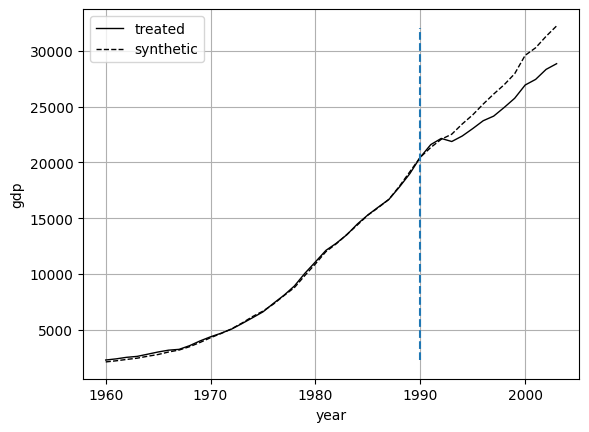

In [5]:
synth.path_plot(treatment_time=1990)

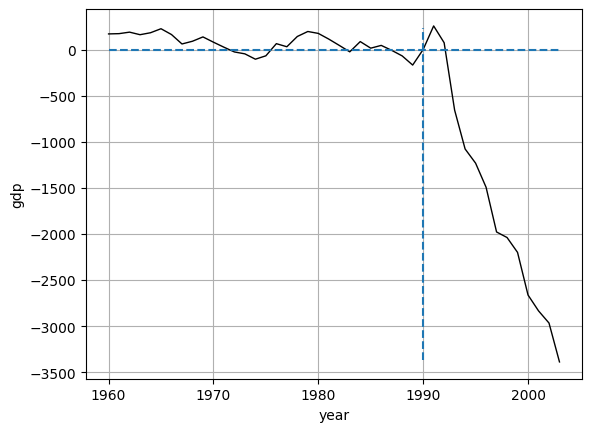

In [6]:
synth.gaps_plot(treatment_time=1990)